In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as pl
import hazel
import h5py
print(hazel.__version__)
label = ['I', 'Q', 'U', 'V']

/scratch/Dropbox/GIT/hazel2/hazel/io.py:12: UserWarning: zarr module not found. You will not be able to use zarr as input/output.
  warnings.warn("zarr module not found. You will not be able to use zarr as input/output.")


2018.06.07


In [2]:
mod_syn = hazel.Model(working_mode='synthesis', verbose=3)
mod_syn.add_spectral({'Name': 'spec1', 'Wavelength': [10826, 10833, 150], 'topology': 'ch1',
    'LOS': [0.0,0.0,90.0], 'Boundary condition': [1.0,0.0,0.0,0.0]})
mod_syn.add_chromosphere({'Name': 'ch1', 'Spectral region': 'spec1', 'Height': 3.0, 'Line': '10830', 
                      'Wavelength': [10826, 10833]})
mod_syn.setup()

2018-10-02 15:11:55,108 - Adding spectral region spec1
2018-10-02 15:11:55,109 -   - Using wavelength axis from 10826.0 to 10833.0 with 150 steps
2018-10-02 15:11:55,110 -   - No mask for pixels
2018-10-02 15:11:55,111 -   - No instrumental profile
2018-10-02 15:11:55,112 -   - Using LOS [0.0, 0.0, 90.0]
2018-10-02 15:11:55,114 -   - Using boundary condition [1.0, 0.0, 0.0, 0.0]
2018-10-02 15:11:55,118 -     * Adding line : 10830
2018-10-02 15:11:55,119 -     * Magnetic field reference frame : vertical
2018-10-02 15:11:55,121 - Adding topologies
2018-10-02 15:11:55,122 -   - ch1
2018-10-02 15:11:55,123 - Removing unused atmospheres
2018-10-02 15:11:55,124 - Number of pixels to read : 1


In [3]:
mod_syn.atmospheres['ch1'].set_parameters([50.0,0.0,100.0,0.2,0.0,8.0,1.0,0.0], 1.0)
mod_syn.synthesize()

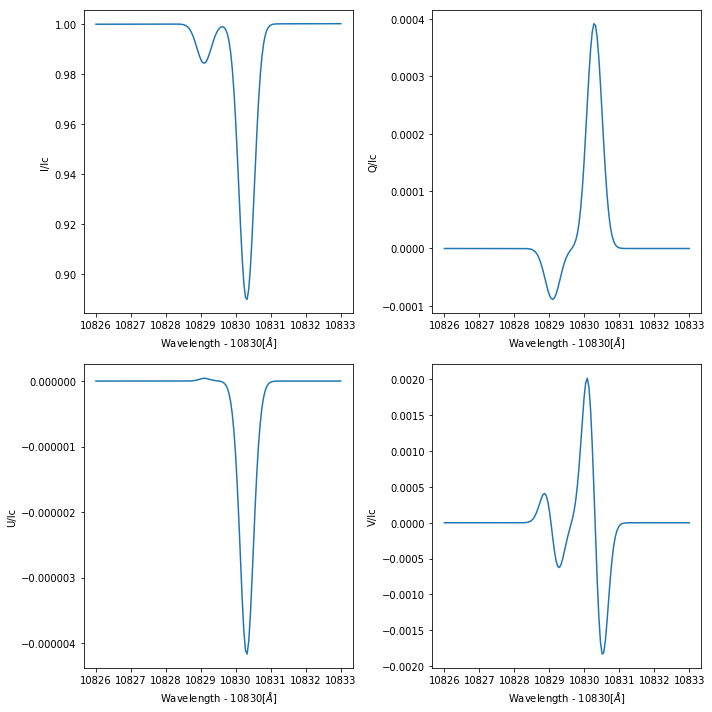

In [4]:
f, ax = pl.subplots(nrows=2, ncols=2, figsize=(10,10))
ax = ax.flatten()
for i in range(4):
    ax[i].plot(mod_syn.spectrum['spec1'].wavelength_axis , mod_syn.spectrum['spec1'].stokes[i,:])

for i in range(4):
    ax[i].set_xlabel('Wavelength - 10830[$\AA$]')
    ax[i].set_ylabel('{0}/Ic'.format(label[i]))
#    ax[i].set_xlim([-2,2])
    
pl.tight_layout()

wvl = mod_syn.spectrum['spec1'].wavelength_axis
n_lambda = len(wvl)

In [5]:
np.savetxt('10830_example.wavelength', wvl, header='lambda')

f = open('10830_example.weights', 'w')
f.write('# WeightI WeightQ WeightU WeightV\n')
for i in range(n_lambda):
    f.write('1.0    1.0   1.0   1.0\n')
f.close()

noise = 1e-5
stokes = np.random.normal(loc=mod_syn.spectrum['spec1'].stokes, scale=noise, size=mod_syn.spectrum['spec1'].stokes.shape)

noise = np.std(stokes[0,0:20])
f = open('10830_example_stokes.1d', 'wb')
f.write(b'# LOS theta_LOS, phi_LOS, gamma_LOS\n')
f.write(b'0.0 0.0 90.0\n')
f.write(b'\n')
f.write(b'# Boundary condition I/Ic(mu=1), Q/Ic(mu=1), U/Ic(mu=1), V/Ic(mu=1)\n')
f.write(b'1.0 0.0 0.0 0.0\n')
f.write(b'\n')
f.write(b'# SI SQ SU SV sigmaI sigmaQ sigmaU sigmaV\n')
tmp = np.vstack([stokes, noise*np.ones((4,n_lambda))])
np.savetxt(f, tmp.T)
f.close()

In [6]:
mod = hazel.Model('../configuration/conf_syn_inv.ini', working_mode='inversion', verbose=3)
mod.read_observation()
mod.open_output()
mod.invert()
mod.write_output()
mod.close_output()

2018-10-02 15:12:08,530 - Adding spectral region spec1
2018-10-02 15:12:08,531 -   - Reading wavelength axis from 10830_example.wavelength
2018-10-02 15:12:08,536 -   - Reading wavelength weights from 10830_example.weights
2018-10-02 15:12:08,547 -   - Using observations from 10830_example_stokes.1d
2018-10-02 15:12:08,550 -   - No mask for pixels
2018-10-02 15:12:08,552 -   - No instrumental profile
2018-10-02 15:12:08,553 -   - Using LOS ['0.0', '0.0', '90.0']
2018-10-02 15:12:08,555 -   - Using boundary condition ['1.0', '0.0', '0.0', '0.0']
2018-10-02 15:12:08,557 - Using 2 cycles
2018-10-02 15:12:08,559 - Not using randomizations
2018-10-02 15:12:08,560 - Adding atmospheres
2018-10-02 15:12:08,562 -   - New available chromosphere : ch1
2018-10-02 15:12:08,564 -     * Adding line : 10830
2018-10-02 15:12:08,566 -     * Magnetic field reference frame : vertical
2018-10-02 15:12:08,568 -     * Reading 1D model ../models/chromospheres/model_chromosphere.1d as reference
2018-10-02 15:1

     Bx        By        Bz        tau       v       deltav      beta      a
   0.000     0.000     0.000     0.245     0.004     8.687     1.000    -0.000


2018-10-02 15:12:10,654 -   * Optimal lambda: 0.0009999999999999994
2018-10-02 15:12:11,022 - It: 1 - chi2: 758.4585161116318 - lambda: 0.0009999999999999994 - rel: -1.9517233012167647


     Bx        By        Bz        tau       v       deltav      beta      a
   0.000     0.000     0.000     0.206    -0.003     8.117     1.000    -0.000


2018-10-02 15:12:11,636 -   * Optimal lambda: 0.000999999999999999
2018-10-02 15:12:11,881 - It: 2 - chi2: 11.470952784220875 - lambda: 0.000999999999999999 - rel: -1.9404051760706276


     Bx        By        Bz        tau       v       deltav      beta      a
   0.000     0.000     0.000     0.202    -0.004     8.006     1.000    -0.000


2018-10-02 15:12:12,242 -   * Optimal lambda: 0.001955271970839425
2018-10-02 15:12:12,435 - It: 3 - chi2: 11.414485519370984 - lambda: 0.001955271970839425 - rel: -0.004934776786951765


     Bx        By        Bz        tau       v       deltav      beta      a
   0.000     0.000     0.000     0.202    -0.004     8.004     1.000    -0.000


2018-10-02 15:12:12,647 -   * Optimal lambda: 0.050282364561486374
2018-10-02 15:12:12,846 - It: 4 - chi2: 11.414484803450037 - lambda: 0.050282364561486374 - rel: -6.272038881212566e-08


     Bx        By        Bz        tau       v       deltav      beta      a
   0.000     0.000     0.000     0.202    -0.004     8.004     1.000    -0.000


2018-10-02 15:12:13,059 - -------------
2018-10-02 15:12:13,060 -   Cycle 1  
2018-10-02 15:12:13,061 -   Weights for region spec1 : SI=0.0 - SQ=10.0 - SU=10.0 - SV=1.0
2018-10-02 15:12:13,062 - -------------
2018-10-02 15:12:13,064 - Free parameters for ch1
2018-10-02 15:12:13,066 -   - Bx with 1 node
2018-10-02 15:12:13,067 -   - By with 1 node
2018-10-02 15:12:13,069 -   - Bz with 1 node
2018-10-02 15:12:14,009 -   * Optimal lambda: 0.0050282364561486355
2018-10-02 15:12:14,354 - It: 0 - chi2: 131.34215395936087 - lambda: 0.0050282364561486355 - rel: 1.68016941552077


     Bx        By        Bz        tau       v       deltav      beta      a
  -0.702     0.702    99.541     0.202    -0.004     8.004     1.000    -0.000


2018-10-02 15:12:15,246 -   * Optimal lambda: 0.5028236456148636
2018-10-02 15:12:15,494 - It: 1 - chi2: 910.5245109241322 - lambda: 0.5028236456148636 - rel: 1.4957429452873483


     Bx        By        Bz        tau       v       deltav      beta      a
-314.183  -305.965   100.154     0.202    -0.004     8.004     1.000    -0.000


2018-10-02 15:12:16,229 -   * Optimal lambda: 0.05028236456148635
2018-10-02 15:12:16,576 - It: 2 - chi2: 219.21416630663356 - lambda: 0.05028236456148635 - rel: -1.2238411564558453


     Bx        By        Bz        tau       v       deltav      beta      a
-103.160  -221.503   152.079     0.202    -0.004     8.004     1.000    -0.000


2018-10-02 15:12:17,341 -   * Optimal lambda: 0.14510635358911608
2018-10-02 15:12:17,629 - It: 3 - chi2: 20.711028106250918 - lambda: 0.14510635358911608 - rel: -1.6547085743632317


     Bx        By        Bz        tau       v       deltav      beta      a
   9.822  -226.928   111.290     0.202    -0.004     8.004     1.000    -0.000


2018-10-02 15:12:18,452 -   * Optimal lambda: 0.014510635358911604
2018-10-02 15:12:18,813 - It: 4 - chi2: 8.35944522612186 - lambda: 0.014510635358911604 - rel: -0.8497682675413736


     Bx        By        Bz        tau       v       deltav      beta      a
  -3.358  -188.258    97.874     0.202    -0.004     8.004     1.000    -0.000


2018-10-02 15:12:19,204 -   * Optimal lambda: 0.00848722076427258
2018-10-02 15:12:19,473 - It: 5 - chi2: 8.070105558872818 - lambda: 0.00848722076427258 - rel: -0.03522185981047023


     Bx        By        Bz        tau       v       deltav      beta      a
  -2.844  -189.860    97.223     0.202    -0.004     8.004     1.000    -0.000


2018-10-02 15:12:19,801 -   * Optimal lambda: 0.09345859416044945
2018-10-02 15:12:20,170 - It: 6 - chi2: 8.070074092447785 - lambda: 0.09345859416044945 - rel: -3.899141857572176e-06


     Bx        By        Bz        tau       v       deltav      beta      a
  -2.840  -189.779    97.192     0.202    -0.004     8.004     1.000    -0.000


(npix,nrand,ncycle,nstokes,nlambda) -> (1, 1, 2, 4, 150)


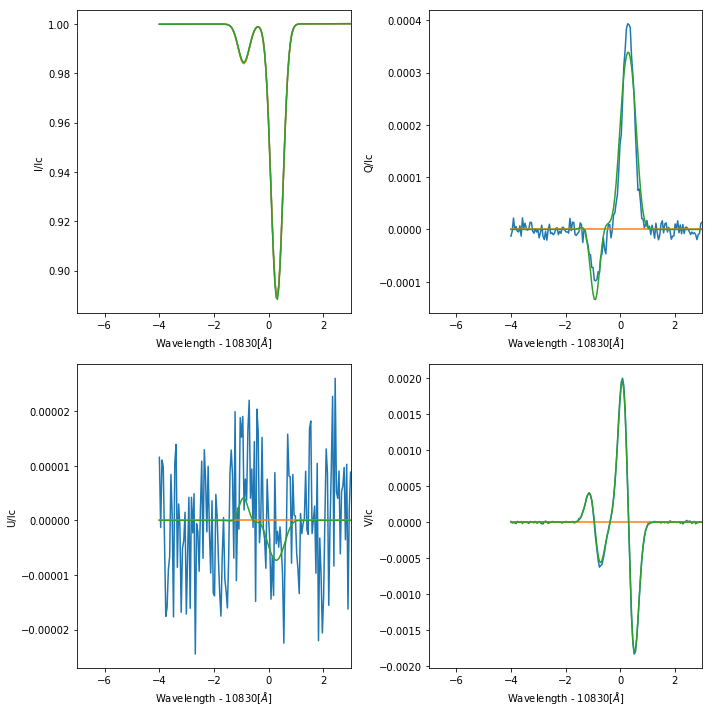

In [7]:
f = h5py.File('output.h5', 'r')

print('(npix,nrand,ncycle,nstokes,nlambda) -> {0}'.format(f['spec1']['stokes'].shape))

fig, ax = pl.subplots(nrows=2, ncols=2, figsize=(10,10))
ax = ax.flatten()
for i in range(4):
    ax[i].plot(f['spec1']['wavelength'][:] - 10830, stokes[i,:])
    for j in range(2):
        ax[i].plot(f['spec1']['wavelength'][:] - 10830, f['spec1']['stokes'][0,0,j,i,:])

for i in range(4):
    ax[i].set_xlabel('Wavelength - 10830[$\AA$]')
    ax[i].set_ylabel('{0}/Ic'.format(label[i]))
    ax[i].set_xlim([-7,3])
    
pl.tight_layout()

f.close()

In [8]:
print('Inversion')
print(mod.atmospheres['ch1'])
print('Original')
print(mod_syn.atmospheres['ch1'])

Inversion
Bx: -2.8401349600205776 G
By: -189.77858846516096 G
Bz: 96.23544870146861 G
tau: 0.20150536080087975 
v: -0.004011190730530245 km/s
deltav: 8.004044777941745 km/s
beta: 1.0 
a: -5.082197683525802e-21 
ff: 1.0 

Original
Bx: 50.0 G
By: 0.0 G
Bz: 100.0 G
tau: 0.2 
v: 0.0 km/s
deltav: 8.0 km/s
beta: 1.0 
a: 0.0 
ff: 1.0 

